# Liver tumors segmentation

Ahmed El Bajdali - ahmed.el-bajdali@student-cs.fr \
Marouane EL Ouarraq - marouane.el-ouarraq@student-cs.fr \
Cyrielle Théobald - cyrielle.theobald@student-cs.fr

## Initialization of the notebook 

### Useful Imports

In [84]:
import os
import csv

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import nibabel as nib
from tqdm import tqdm
import time 

from matplotlib.widgets import Slider
import ipywidgets as widgets
from ipywidgets import interact

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split

import nibabel as nib
import logging
nib_logger = logging.getLogger("nibabel")
nib_logger.setLevel(logging.ERROR)

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [86]:
class LiverSegmentationConfig:
    """Configuration class for liver tumor segmentation"""

    def __init__(self):
        self.train_dir = '/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6'
        self.labels_dir = '/kaggle/input/liver-tumor-segmentation/segmentations'

        self.volume_paths = list()
        self.seg_paths = list()

        # Parameters
        self.n_classes = 1
        self.window_size = (-20,120)
        self.batch_size = 16
        self.learning_rate = 1e-3
        self.target_size = 128

    def _init_paths(self):
        """Initialize volume and segmentation paths"""
        for file in os.listdir(self.train_dir):
            if file.endswith('.nii'):
                vol_path = os.path.join(self.train_dir, file)
                seg_file = file.replace('volume', 'segmentation')
                seg_path = os.path.join(self.labels_dir, seg_file)
                
                if os.path.exists(seg_path):
                    self.volume_paths.append(vol_path)
                    self.seg_paths.append(seg_path)
        self.volume_paths = self.volume_paths[:5] # less pictures for faster training
        self.seg_paths = self.seg_paths[:5] # less pictures for faster training
        
        print(f"Found {len(self.volume_paths)} volumes and {len(self.seg_paths)} segmentations")

In [87]:
config = LiverSegmentationConfig()
config._init_paths()

print(f"Example of a volume path: {config.volume_paths[4]}")
print(f"Example of a segmentation path: {config.seg_paths[4]}")

Found 5 volumes and 5 segmentations
Example of a volume path: /kaggle/input/liver-tumor-segmentation-part-2/volume_pt6/volume-66.nii
Example of a segmentation path: /kaggle/input/liver-tumor-segmentation/segmentations/segmentation-66.nii


## Visualization 

In [88]:
index = 4

image_path = config.volume_paths[index]
data = nib.load(image_path).get_fdata().transpose(2,1,0)
segmentation = nib.load(config.seg_paths[index]).get_fdata().transpose(2,1,0)

def update(orientation):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data[orientation], cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(segmentation[orientation], cmap='gray')
    axes[1].set_title("Segmented Image") 
    plt.show()

interact(update, orientation = widgets.IntSlider(min=0, max=len(data)-1, step=1, value=3*len(data)//4));

interactive(children=(IntSlider(value=64, description='orientation', max=85), Output()), _dom_classes=('widget…

## Preprocessing and Data loading

In [89]:
def preprocessing(scan: np.ndarray, window: tuple = (-20,120), new_size=config.target_size) -> np.ndarray:
    """Applying windowing for given Data and Normalizing"""
    min_value, max_value = window

    scan = cv2.resize(scan, (new_size, new_size), interpolation = cv2.INTER_AREA)
    
    windowed_scan = np.clip(scan, min_value, max_value) # Windowing
    normalized_scan = ((windowed_scan - min_value) / (max_value - min_value)) # Normalization

    return normalized_scan

def preprocessing_mask(mask: np.ndarray, new_size=config.target_size):
    mask = cv2.resize(mask, (new_size, new_size), interpolation = cv2.INTER_AREA)
    mask = (mask > 0).astype(np.float32)
    return mask

### Visualize preprocessing

In [90]:
index = 4

image_path = config.volume_paths[index]
data = nib.load(image_path).get_fdata().transpose(2,1,0)
segmentation = nib.load(config.seg_paths[index]).get_fdata().transpose(2,1,0)

def update_with_preprocessing(slice_id):
    raw_slice = data[slice_id]
    preprocessed = preprocessing(raw_slice)
    seg_slice = segmentation[slice_id]
    seg_slice = preprocessing_mask(seg_slice)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(raw_slice, cmap='gray')
    axes[0].set_title("Original Slice")

    axes[1].imshow(preprocessed, cmap='gray')
    axes[1].set_title("Preprocessed")

    axes[2].imshow(seg_slice, cmap='gray')
    axes[2].set_title("Segmentation Mask")

    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

interact(update_with_preprocessing, slice_id = widgets.IntSlider(min=0, max=len(data)-1, step=1, value=3*len(data)//4));

interactive(children=(IntSlider(value=64, description='slice_id', max=85), Output()), _dom_classes=('widget-in…

### Dataloader

In [ ]:
class SlicesDataset(Dataset):
    def __init__(self, volume_paths, seg_paths, transform = preprocessing, transform_mask = preprocessing_mask):
        self.volume_paths = volume_paths
        self.seg_paths = seg_paths
        self.transform = transform
        self.transform_mask = transform_mask
        self.slice_info = self._get_slice_info()

    def _get_slice_info(self):
        slice_info = []
        for vol_idx, volume_paths in enumerate(self.volume_paths):
            vol = nib.load(volume_paths)
            num_slices = vol.shape[2]
            for slice_idx in range(num_slices//2,num_slices): # less slices for faster training
                slice_info.append((vol_idx, slice_idx))
        return slice_info

    def __len__(self):
        return len(self.slice_info)

    def __getitem__(self, idx):
        vol_idx, slice_idx = self.slice_info[idx]
    
        vol = nib.load(self.volume_paths[vol_idx]).get_fdata()
        seg = nib.load(self.seg_paths[vol_idx]).get_fdata()
    
        slice_vol = vol[:, :, slice_idx]         # Shape (512, 512)
        slice_seg = seg[:, :, slice_idx]         # (512, 512)
    
        X = self.transform(slice_vol)            # (256, 256)
        Y = self.transform_mask(slice_seg)       # (256, 256)
    
        X = np.expand_dims(X, axis=0)            # (1, 256, 256)
        Y = np.expand_dims(Y, axis=0)            # (1, 256, 256)
    
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)
    
        return X, Y

In [92]:
X_train, X_test, Y_train, Y_test = train_test_split(config.volume_paths, config.seg_paths, test_size = 0.2, random_state = 0)

In [93]:
train_dataset = SlicesDataset(X_train, Y_train, transform = preprocessing, transform_mask=preprocessing_mask)
test_dataset = SlicesDataset(X_test, Y_test, transform = preprocessing, transform_mask=preprocessing_mask)

In [94]:
train_dataloader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = config.batch_size, shuffle = False)

## Define the model

In [95]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_channels=1, out_channels=config.n_classes):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        # Encoder path
        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Decoder path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, config.n_classes, kernel_size=1)
        
    def forward(self, x):
        
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))

        # Bottleneck
        x = self.bottleneck(self.pool4(x4))

        # Decoder
        x = self.upconv4(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec4(x)

        x = self.upconv3(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3(x)

        x = self.upconv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)

        x = self.upconv1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)

        return self.final_conv(x)

### Metrics

In [ ]:
def compute_metrics(outputs, targets, epsilon=1e-8):
    """
    Computes Dice score, Dice loss, IoU, Precision, and Recall.
    
    Args:
        outputs (torch.Tensor): Predicted mask (probabilistic).
        target (torch.Tensor): Ground truth mask.
        epsilon (float): Small value to avoid division by zero.
    
    Returns:
        dict: A dictionary containing all computed metrics.
    """
    classification = (outputs > 0.5).float()
    targets = targets.float()
    
    # Dice Score
    intersection = torch.sum(classification * targets, dim=(1,2,3))
    union = torch.sum(classification, dim=(1,2,3)) + torch.sum(targets, dim=(1,2,3))
    dice = ((2. * intersection + epsilon) / (union + epsilon)).mean()

    # Dice Loss
    bce_loss = 1/2*(nn.functional.binary_cross_entropy_with_logits(outputs, targets) + 1 - dice)

    # IoU
    iou_inter = (classification * targets).sum()
    iou_union = classification.sum() + targets.sum() - iou_inter
    iou = (iou_inter / (iou_union)).item() if iou_union > 0 else 1.0

    # Precision
    tp = (classification * targets).sum()
    fp = (classification * (1 - targets)).sum()
    precision = (tp / (tp + fp + epsilon))

    # Recall
    fn = ((1 - classification) * targets).sum()
    recall = (tp / (tp + fn + epsilon))

    return {
        "dice_score": dice.item(),
        "bce_loss": bce_loss.item(),
        "iou_score": iou,
        "precision": precision.item(),
        "recall": recall.item()
    }

In [124]:
model = UNet().to(device)
print(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Con

In [125]:
criterion = nn.functional.binary_cross_entropy_with_logits
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
num_epochs = 100

log_file = "UNet.csv"  
log_fields = ["epoch", "time", 
              "train_loss", "val_loss", 
              "dice_train", "dice_val", 
              "mIou_train", "mIou_val", 
              "precision_train", "precision_val", 
              "recall_train", "recall_val",]

In [126]:
def validation_metrics(model, dataloader):
    val_loss = 0.0
    val_dice = 0.0
    val_iou = 0.0
    val_recall = 0.0
    val_precision = 0.0

    model.eval()
    
    val_iterator = tqdm(dataloader, desc=f"Validation...", leave = False)
    with torch.no_grad():
        for inputs, segmentation_masks in val_iterator:
            inputs = inputs.to(device)
            segmentation_masks = segmentation_masks.to(device)
            
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)

            loss = criterion(outputs, segmentation_masks)
            
            metrics = compute_metrics(outputs, segmentation_masks)
            
            val_loss += metrics['bce_loss']
            val_dice += metrics['dice_score']
            val_iou += metrics['iou_score']
            val_recall += metrics['recall']
            val_precision += metrics['precision']

    return (val_loss/ len(dataloader)),(val_dice/ len(dataloader)), (val_iou/ len(dataloader)), (val_recall/ len(dataloader)),(val_precision/ len(dataloader))

def log_metrics_to_csv(epoch, epoch_time, train_metrics, val_metrics):
    with open(log_file, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=log_fields)
        writer.writerow({
            "epoch": epoch,
            "time": epoch_time,
            "train_loss": train_metrics['bce_loss'],
            "val_loss": val_metrics['bce_loss'],
            "dice_train": train_metrics['dice_score'],
            "dice_val": val_metrics['dice_score'],
            "mIou_train": train_metrics['iou_score'],
            "mIou_val": val_metrics['iou_score'],
            "precision_train": train_metrics['precision'],
            "precision_val": val_metrics['precision'],
            "recall_train": train_metrics['recall'],
            "recall_val": val_metrics['recall']
        })

In [127]:
def visualize_prediction(model, index, orientation=63):
    model.eval()
    with torch.no_grad():
        try:
            # Load volume and mask
            image_path = config.volume_paths[index]
            mask_path = config.seg_paths[index]
            data = nib.load(image_path).get_fdata().transpose(2, 1, 0)
            mask = nib.load(mask_path).get_fdata().transpose(2, 1, 0)

            # Select slice
            image_slice = data[orientation]
            image_slice = preprocessing(image_slice)
            mask_slice = mask[orientation]

            # Preprocess (resize, normalize, convert to tensor)
            image_tensor = torch.tensor(image_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
            # image_tensor = F.interpolate(image_tensor, size=(256, 256), mode='bilinear')  # 
            image_tensor = image_tensor.to(device)

            # Prediction
            output = torch.sigmoid(model(image_tensor))
            pred_mask = (output > 0.5).float().squeeze().cpu().numpy()

            # Resize mask_slice to match prediction for fair display
            mask_tensor = torch.tensor(mask_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            mask_tensor = F.interpolate(mask_tensor, size=(256, 256), mode='nearest')
            mask_resized = mask_tensor.squeeze().numpy()

            # Plot
            fig, axes = plt.subplots(1, 3, figsize=(10, 6))
            axes[0].imshow(image_tensor.squeeze().cpu(), cmap='gray')
            axes[0].set_title("Input Image")
            axes[1].imshow(mask_resized, cmap='gray')
            axes[1].set_title("Ground Truth")
            axes[2].imshow(pred_mask, cmap='gray')
            axes[2].set_title("Prediction")
            for ax in axes:
                ax.axis('off')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Could not load or process image: {e}")

def run_one_epoch(model, optimizer, criterion, train_dataloader, test_dataloader,
                  epoch, best_dice, save_path, checkpoint_path, log_file, log_fields):
    
    model.train()
    epoch_start_time = time.time()

    train_iterator = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}")
    running_metrics = {'bce_loss': 0.0, 'dice_score': 0.0, 'iou_score': 0.0, 'precision': 0.0, 'recall': 0.0}

    for i, (inputs, masks) in train_iterator:
        inputs, masks = inputs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = torch.sigmoid(model(inputs))
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        metrics = compute_metrics(outputs, masks)

        running_metrics['bce_loss'] += metrics['bce_loss']
        running_metrics['dice_score'] += metrics['dice_score']
        running_metrics['iou_score'] += metrics['iou_score']
        running_metrics['precision'] += metrics['precision']
        running_metrics['recall'] += metrics['recall']

        avg_metrics = {k: v / (i + 1) for k, v in running_metrics.items()}
        train_iterator.set_postfix({
            'bce_loss': f"{avg_metrics['bce_loss']:.4f}",
            'dice_score': f"{avg_metrics['dice_score']:.4f}",
            'iou_score': f"{avg_metrics['iou_score']:.4f}",
            'precision': f"{avg_metrics['precision']:.4f}",
            'recall': f"{avg_metrics['recall']:.4f}"
        })

    # Validation
    val_loss, val_dice, val_iou, val_recall, val_precision = validation_metrics(model, test_dataloader)
    val_metrics = {
        'bce_loss': val_loss,
        'dice_score': val_dice,
        'iou_score': val_iou,
        'precision': val_precision,
        'recall': val_recall
    }

    # Save best model
    if val_dice > best_dice:
        torch.save(model.state_dict(), save_path)
        best_dice = val_dice
        print(f"Epoch {epoch+1}: New best model saved with Dice {val_dice:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_dice': best_dice
    }, checkpoint_path)

    # Log
    epoch_time = time.time() - epoch_start_time
    log_metrics_to_csv(epoch, epoch_time, avg_metrics, val_metrics)

    return best_dice


=== Epoch 1 ===


Epoch 1: 100%|██████████| 16/16 [06:12<00:00, 23.28s/it, bce_loss=1.5201, dice_score=0.2266, iou_score=0.0000, precision=0.0000, recall=0.0000]


Epoch 1: New best model saved with Dice 0.2118

=== Epoch 2 ===


Epoch 2: 100%|██████████| 16/16 [06:16<00:00, 23.53s/it, bce_loss=1.4666, dice_score=0.2266, iou_score=0.0000, precision=0.0000, recall=0.0000]



=== Epoch 3 ===


Epoch 3: 100%|██████████| 16/16 [06:09<00:00, 23.09s/it, bce_loss=1.4783, dice_score=0.2148, iou_score=0.0000, precision=0.0000, recall=0.0000]



=== Epoch 4 ===


Epoch 4: 100%|██████████| 16/16 [06:10<00:00, 23.13s/it, bce_loss=1.4783, dice_score=0.2148, iou_score=0.0000, precision=0.0000, recall=0.0000]



=== Epoch 5 ===


Epoch 5: 100%|██████████| 16/16 [06:26<00:00, 24.14s/it, bce_loss=1.4666, dice_score=0.2266, iou_score=0.0000, precision=0.0000, recall=0.0000]



=== Epoch 6 ===


Epoch 6: 100%|██████████| 16/16 [06:21<00:00, 23.82s/it, bce_loss=1.4549, dice_score=0.2383, iou_score=0.0000, precision=0.0000, recall=0.0000]



=== Epoch 7 ===


Epoch 7: 100%|██████████| 16/16 [06:05<00:00, 22.82s/it, bce_loss=1.4666, dice_score=0.2266, iou_score=0.0000, precision=0.0000, recall=0.0000]



=== Epoch 8 ===


Epoch 8: 100%|██████████| 16/16 [06:21<00:00, 23.82s/it, bce_loss=1.4666, dice_score=0.2266, iou_score=0.0000, precision=0.0000, recall=0.0000]



=== Epoch 9 ===


Epoch 9: 100%|██████████| 16/16 [06:27<00:00, 24.22s/it, bce_loss=1.4666, dice_score=0.2266, iou_score=0.0000, precision=0.0000, recall=0.0000]



=== Epoch 10 ===


Epoch 10: 100%|██████████| 16/16 [06:22<00:00, 23.93s/it, bce_loss=1.4783, dice_score=0.2148, iou_score=0.0000, precision=0.0000, recall=0.0000]


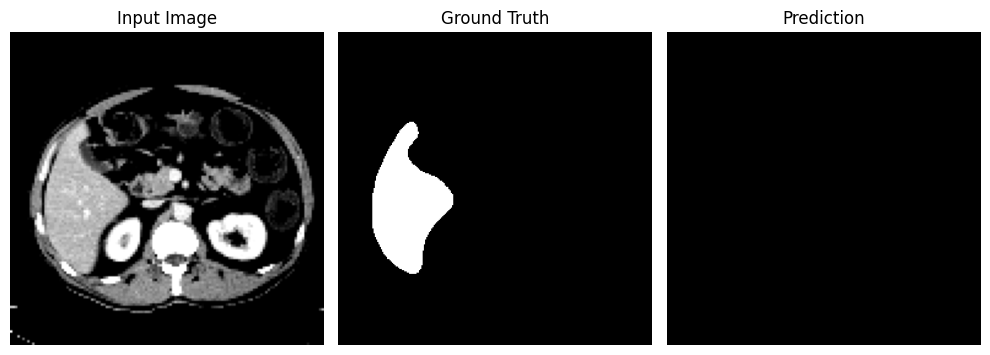

In [128]:
best_dice = 0

with open(log_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=log_fields)
    writer.writeheader()

for current_epoch in range(10):
    print(f"\n=== Epoch {current_epoch+1} ===")
    best_dice = run_one_epoch(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        epoch=current_epoch,
        best_dice=best_dice,
        save_path="/kaggle/working/trained_unet.pt",
        checkpoint_path="/kaggle/working/last_checkpoint.pt",
        log_file=log_file,
        log_fields=log_fields
    )
visualize_prediction(model, 4, 63)

## To test the model

In [ ]:
model = UNet().to(device)
model.load_state_dict(torch.load("/kaggle/input/unet_liver/other/default/1/trained_unet.pt"))
model.eval()

/tmp/ipykernel_31/3541181264.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/unet_liver/other/default/1/trained_unet.pt")

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Con

In [ ]:
test_metrics = {'loss': 0.0, 'dice_score': 0.0, 'iou_score': 0.0, 'precision': 0.0, 'recall': 0.0}

with torch.no_grad():
    test_iterator = tqdm(test_dataloader, desc="Test", leave=False)
    for inputs, masks in test_iterator:
        inputs, masks = inputs.to(device), masks.to(device)
        
        outputs = torch.sigmoid(model(inputs))
        loss = criterion(outputs, masks)
        
        metrics = compute_metrics(outputs, masks)
        
        test_metrics['loss'] += metrics['bce_loss']
        test_metrics['dice_score'] += metrics['dice_score']
        test_metrics['iou_score'] += metrics['iou_score']
        test_metrics['precision'] += metrics['precision']
        test_metrics['recall'] += metrics['recall']

# Average the metrics over the test dataset
num_batches = len(test_dataloader)
test_metrics = {k: v / num_batches for k, v in test_metrics.items()}

# Print the metrics
print("Test Metrics:")
print(f"Loss: {test_metrics['loss']:.4f}")
loss_final = test_metrics['dice_score']
print(f"Dice Score: {loss_final:.4f}")
print(f"IoU: {test_metrics['iou_score']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")

Test Metrics:
Loss: 1.2851
Dice Score: 0.8997
IoU: 0.8389
Precision: 0.7855
Recall: 0.8687
